In [26]:
# import some packages
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F


In [27]:
# hyper parameters definitions
'''
BATCH_SIZE    批大小
LR            学习率
EPOCH         迭代次数
'''
BATCH_SIZE = 50
LR = 0.003
EPOCH = 10

In [28]:
# download the MNIST dataset
train_data = torchvision.datasets.MNIST(
    root = './data/',
    train = True,
    transform=torchvision.transforms.ToTensor(),
)

test_data = torchvision.datasets.MNIST(
    root = './data/',
    train=False,
    transform=torchvision.transforms.ToTensor()
)


In [29]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    shuffle = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    shuffle = True,
)

In [30]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout2d(0.4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout2d(0.3)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.dropout1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.dropout2(x)  #
        x = x.view(-1, 64 * 7 * 7)  # 展平
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [31]:
cnn = CNN()
# add optimizer and loss function
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)

# using cross entropy as loss function for one-hotted
criterion = torch.nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(cnn)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0.4, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [32]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()  # 将模型设置为训练模式
    running_loss = 0.0  # 初始化损失值为0
    correct = 0  # 初始化预测正确的样本数为0
    total = 0  # 初始化总样本数为0

    loop = tqdm(train_loader, total=len(train_loader))  # 使用 tqdm 创建进度条
    loop.set_description()

    for i, (images, labels) in enumerate(loop):  # 遍历训练数据集，并使用 enumerate 获取批次索引
        images, labels = images.to(device), labels.to(device)  # 将输入数据和标签移动到指定的设备上（例如GPU）

        optimizer.zero_grad()  # 清零梯度，以防止梯度累积
        outputs = model(images)  # 前向传播：通过模型获取预测输出
        loss = criterion(outputs, labels)  # 计算损失值
        loss.backward()  # 反向传播：计算梯度
        optimizer.step()  # 更新模型参数

        # 计算损失和准确率
        running_loss += loss.item()  # 累加损失值
        _, predicted = outputs.max(1)  # 获取预测结果中的最大值及其对应的索引
        total += labels.size(0)  # 累加样本数量
        correct += predicted.eq(labels).sum().item()  # 累加预测正确的样本数量

        # 更新进度条显示
        loop.set_description(f'Training Process [{i+1}/{len(train_loader)}]')
        loop.set_postfix(loss=running_loss/(i+1), acc=correct/total)

    # 计算平均损失和准确率
    train_loss = running_loss / len(train_loader)  # 计算平均损失
    train_acc = correct / total  # 计算平均准确率

    return train_loss, train_acc

def test(model, test_loader, criterion, device):
    model.eval()  # 将模型设置为评估模式
    running_loss = 0.0  # 初始化损失值为0
    correct = 0  # 初始化预测正确的样本数为0
    total = 0  # 初始化总样本数为0

    loop = tqdm(test_loader, total=len(test_loader))  # 使用 tqdm 创建进度条
    loop.set_description(f'Testing Starting ...')

    with torch.no_grad():  # 在评估过程中，不需要计算梯度
        for i, (images, labels) in enumerate(loop):  # 遍历测试数据集，并使用 enumerate 获取批次索引
            images, labels = images.to(device), labels.to(device)  # 将输入数据和标签移动到指定的设备上（例如GPU）

            outputs = model(images)  # 前向传播：通过模型获取预测输出
            loss = criterion(outputs, labels)  # 计算损失值

                # 计算损失和准确率
            running_loss += loss.item()  # 累加损失值
            _, predicted = outputs.max(1)  # 获取预测结果中的最大值及其对应的索引
            total += labels.size(0)  # 累加样本数量
            correct += predicted.eq(labels).sum().item()  # 累加预测正确的样本数量

                # 更新进度条显示
            loop.set_description(f'Testing Process [{i+1}/{len(test_loader)}]')
            loop.set_postfix(loss=running_loss/(i+1), acc=correct/total)

        # 计算平均损失和准确率
        test_loss = running_loss / len(test_loader)  # 计算平均损失
        test_acc = correct / total  # 计算平均准确率

        return test_loss, test_acc

In [33]:
def run(EPOCHS, model, train_loader, test_loader, optimizer, criterion, device):
    num_epochs = EPOCHS  # 设置训练 epoch 数
    test_loss_v = []
    test_acc_v = []

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch: {epoch}')
        print('===>Train Start')
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        print('===>Test Start')
        test_loss, test_acc = test(model, test_loader, criterion, device)
        test_loss_v.append(test_loss)
        test_acc_v.append(test_acc)

    # 可视化训练损失和准确率
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), test_loss_v, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Testing Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), test_acc_v, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch: 1
===>Train Start


Training Process [1200/1200]: 100%|██████████| 1200/1200 [00:31<00:00, 37.57it/s, acc=0.946, loss=0.174]


===>Test Start


Testing Process [200/200]: 100%|██████████| 200/200 [00:03<00:00, 63.73it/s, acc=0.986, loss=0.0474]


Epoch: 2
===>Train Start


Training Process [1200/1200]: 100%|██████████| 1200/1200 [00:28<00:00, 41.50it/s, acc=0.978, loss=0.0734]


===>Test Start


Testing Process [200/200]: 100%|██████████| 200/200 [00:02<00:00, 68.41it/s, acc=0.987, loss=0.0391]


Epoch: 3
===>Train Start


Training Process [1200/1200]: 100%|██████████| 1200/1200 [00:26<00:00, 44.91it/s, acc=0.982, loss=0.0599]


===>Test Start


Testing Process [200/200]: 100%|██████████| 200/200 [00:02<00:00, 74.65it/s, acc=0.988, loss=0.0361]


Epoch: 4
===>Train Start


Training Process [1200/1200]: 100%|██████████| 1200/1200 [00:25<00:00, 46.52it/s, acc=0.984, loss=0.0513]


===>Test Start


Testing Process [200/200]: 100%|██████████| 200/200 [00:02<00:00, 79.36it/s, acc=0.99, loss=0.0359] 


Epoch: 5
===>Train Start


Training Process [1200/1200]: 100%|██████████| 1200/1200 [00:27<00:00, 43.18it/s, acc=0.985, loss=0.0491]


===>Test Start


Testing Process [200/200]: 100%|██████████| 200/200 [00:03<00:00, 58.48it/s, acc=0.987, loss=0.0416]


Epoch: 6
===>Train Start


Training Process [1200/1200]: 100%|██████████| 1200/1200 [00:29<00:00, 40.85it/s, acc=0.986, loss=0.0448]


===>Test Start


Testing Process [200/200]: 100%|██████████| 200/200 [00:02<00:00, 70.32it/s, acc=0.988, loss=0.0376]


Epoch: 7
===>Train Start


Training Process [1200/1200]: 100%|██████████| 1200/1200 [00:30<00:00, 39.81it/s, acc=0.987, loss=0.0423]


===>Test Start


Testing Process [200/200]: 100%|██████████| 200/200 [00:02<00:00, 70.24it/s, acc=0.99, loss=0.0344] 


Epoch: 8
===>Train Start


Training Process [1200/1200]: 100%|██████████| 1200/1200 [00:28<00:00, 42.06it/s, acc=0.987, loss=0.0408]


===>Test Start


Testing Process [200/200]: 100%|██████████| 200/200 [00:02<00:00, 74.63it/s, acc=0.99, loss=0.0373] 


Epoch: 9
===>Train Start


Training Process [1200/1200]: 100%|██████████| 1200/1200 [00:33<00:00, 35.73it/s, acc=0.988, loss=0.0393]


===>Test Start


Testing Process [200/200]: 100%|██████████| 200/200 [00:02<00:00, 70.47it/s, acc=0.99, loss=0.0345] 


Epoch: 10
===>Train Start


Training Process [1200/1200]: 100%|██████████| 1200/1200 [00:32<00:00, 36.73it/s, acc=0.989, loss=0.036] 


===>Test Start


Testing Process [200/200]: 100%|██████████| 200/200 [00:02<00:00, 72.73it/s, acc=0.99, loss=0.0383] 


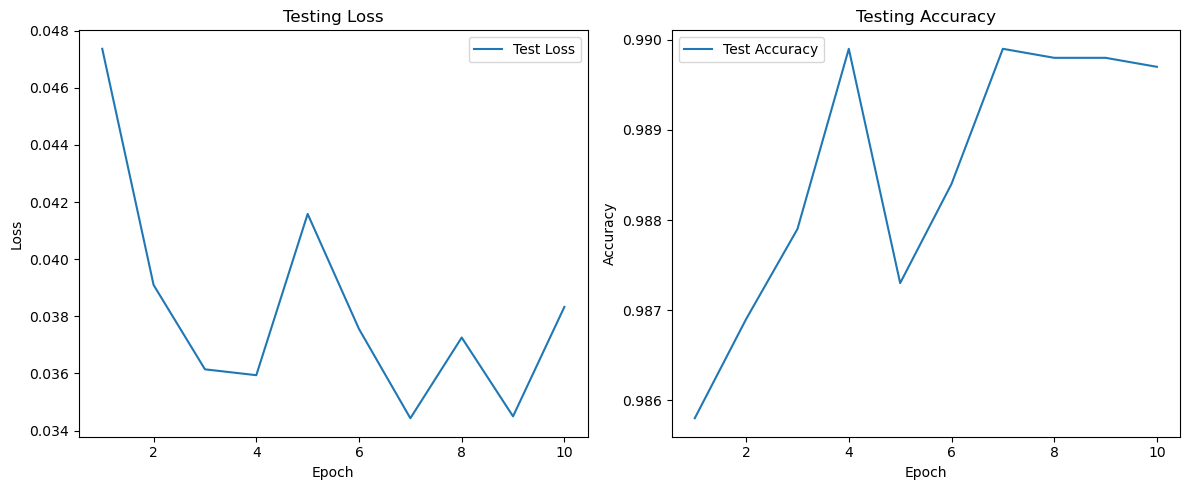

In [34]:
run(EPOCH, cnn, train_loader, test_loader, optimizer, criterion, device)

In [35]:
from torchsummary import summary
summary(cnn, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         Dropout2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         Dropout2d-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 128]         401,536
            Linear-6                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 1.61
Estimated Total Size (MB): 1.97
----------------------------------------------------------------


In [36]:
torch.save(cnn, 'cnn_v2.1.pth')